# Vehicle Detection

In [1]:
import glob
import matplotlib.pyplot as plt
import cv2
from skimage.feature import hog
from scipy.ndimage.measurements import label
%matplotlib inline
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from sklearn.preprocessing import StandardScaler
import numpy as np

from keras.models import Sequential
from keras.layers import Dense, Convolution2D, Activation, MaxPooling2D, Flatten, Lambda, Dropout
import numpy as np
from sklearn.model_selection import train_test_split
from skimage.util import view_as_windows

Using TensorFlow backend.


### Data exploration

In [2]:
vehicles = glob.glob('vehicles/*/*.png')
non_vehicles = glob.glob('non-vehicles/*/*.png')

print("Number of vehicle images is %s" % len(vehicles))
print("Number of non vehicle images is %s" % len(non_vehicles))

Number of vehicle images is 8792
Number of non vehicle images is 8968


### Train classifier on extracted features from training set

In [3]:
features_train = []
images = vehicles + non_vehicles
labels_train = []
labels_train[0:len(vehicles)] = [1] * len(vehicles)
labels_train[len(vehicles):] = [0] * len(non_vehicles)
for image in images:
    img = cv2.imread(image)
    img = cv2.resize(img, (32, 32))
    features_train.append(img)

x_train, x_test, y_train, y_test = train_test_split(features_train, labels_train, test_size=0.2)

In [4]:
model = Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(32,32,3)))
model.add(Convolution2D(20, 5, 5, border_mode="valid"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Convolution2D(50, 5, 5, border_mode="valid"))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Flatten())
model.add(Dense(400))
model.add(Activation("relu"))
model.add(Dense(120))
model.add(Activation("relu"))
model.add(Dropout(0.7))
model.add(Dense(84))
model.add(Activation("relu"))
model.add(Dropout(0.7))
model.add(Dense(1))
model.add(Activation("sigmoid"))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()
model.fit(np.array(x_train), np.array(y_train), validation_split=0.2, shuffle=True, nb_epoch=15)
loss, acc = model.evaluate(np.array(x_test), np.array(y_test), verbose=0)

print('\nTesting accuracy: {}\n'.format(acc))

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 32, 32, 3)     0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 28, 28, 20)    1520        lambda_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 28, 28, 20)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 14, 14, 20)    0           activation_1[0][0]               
___________________________________________________________________________________________

### Implement sliding window to search for vehicles in the image 

In [27]:
class Pipeline:
    def __init__(self, model, threshold, debug=0):
        self.model = model
        self.threshold = threshold
        self.heatmaps = []
        self.debug = debug
    
    def add_heat(self, image, bbox_list):
        new_heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
        for box in bbox_list:
            new_heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

        if len(self.heatmaps) >= 10:
            self.heatmaps = self.heatmaps[1:]
        self.heatmaps.append(new_heatmap)

        heatmap = sum(self.heatmaps)
        heatmap[heatmap <= self.threshold] = 0
        if self.debug > 0:
            plt.figure()
            plt.title('Heatmap')
            plt.imshow(heatmap, cmap='hot')
            scale = 255/np.amax(heatmap)
            cv2.imwrite('./processed/heatmap.jpg', heatmap*scale)
        return label(heatmap)

    
    def draw_labeled_bboxes(self, img, labels):
        for car_number in range(1, labels[1]+1):
            nonzero = (labels[0] == car_number).nonzero()
            nonzeroy = np.array(nonzero[0])
            nonzerox = np.array(nonzero[1])
            bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
            cv2.rectangle(img, bbox[0], bbox[1], (0,220,0), 2)
        return img    
    

    def find_cars_lenet(self, img, ystart, ystop, search_size_x, search_size_y, overlap=0.75):
        preprocessed = img[ystart:ystop,:]
    
        if self.debug > 0:
            plt.figure()
            plt.imshow(cv2.cvtColor(preprocessed, cv2.COLOR_BGR2RGB))
            cv2.imwrite('./processed/preprocessed_' + str(search_size_x) + '.jpg', preprocessed)
    
        search_window = (search_size_x, search_size_y, 3)
        move_x = int(search_size_x * (1 - overlap))
        move_y = int(search_size_y * (1 - overlap))
        move = (move_x, move_y, 3)
        windows = view_as_windows(preprocessed, search_window, move)
        y = windows.shape[0]
        x = windows.shape[1]
    
        boxes = []
        for i in range(x):
            for j in range(y):
                current_frame = windows[j][i][0]
                if search_size_x != 32 or search_size_y != 32:
                    current_frame = cv2.resize(current_frame, (32, 32))
                prediction = self.model.predict(np.array([current_frame]))
                if prediction[0][0] > 0.9:
                    boxes.append(((i*move_x, j*move_y+ystart), (i*move_x+search_size_x, j*move_y+search_size_y+ystart)))
                    if self.debug > 1:
                        plt.figure()
                        plt.imshow(cv2.cvtColor(current_frame, cv2.COLOR_BGR2RGB))

        return boxes
    
    
    def process(self, img):
        if self.debug > 0:
            # Debug mode, running on a test frame, need to load image first
            img = cv2.imread(img)
        else:
            # Video mode, frames are given in RGB
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        
        boxes_small = self.find_cars_lenet(img, 400, 528, 64, 64)
        boxes_medium = self.find_cars_lenet(img, 400, 656, 128, 128)
        boxes_large = self.find_cars_lenet(img, 400, 656, 256, 256)
        labels = self.add_heat(img, boxes_small + boxes_medium + boxes_large)

        processed = self.draw_labeled_bboxes(img, labels)
        if self.debug > 0:
            plt.figure()
            plt.title('Output image')
            plt.imshow(cv2.cvtColor(processed, cv2.COLOR_BGR2RGB))
            cv2.imwrite('./processed/output.jpg', processed)
        else:
            processed = cv2.cvtColor(processed, cv2.COLOR_BGR2RGB)
        return processed

### Test the pipeline on a single frame

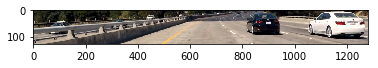

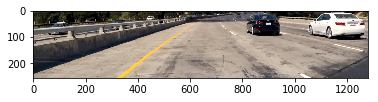

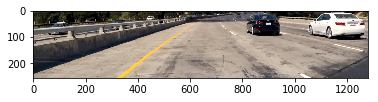

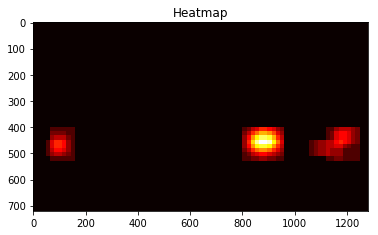

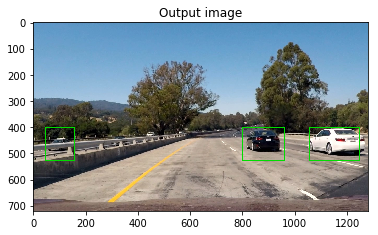

In [28]:
pipeline = Pipeline(model, 1, 1)
pipeline.process('test_images/test1.jpg');

### Process the test video

In [18]:
pipeline = Pipeline(model, 10, 0)
white_output = 'output/test_video.mp4'
clip1 = VideoFileClip("test_video.mp4") #.subclip(22, 24)
white_clip = clip1.fl_image(pipeline.process)
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video output/test_video.mp4
[MoviePy] Writing video output/test_video.mp4


 97%|█████████▋| 38/39 [00:26<00:00,  1.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output/test_video.mp4 

CPU times: user 56.8 s, sys: 9.7 s, total: 1min 6s
Wall time: 27.1 s


### Process the project video

In [19]:
pipeline = Pipeline(model, 10, 0)
white_output = 'output/project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(pipeline.process)
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video output/project_video.mp4
[MoviePy] Writing video output/project_video.mp4


100%|█████████▉| 1260/1261 [14:33<00:00,  1.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output/project_video.mp4 

CPU times: user 31min 18s, sys: 5min 23s, total: 36min 41s
Wall time: 14min 34s


### Obsolete code not used in the final pipeline

In [ ]:
def grayscale(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def get_hog_features(img, orient, pix_per_cell, cell_per_block, feature_vec=False, debug=0):
    '''
    Method used to get the hog features for the image
    '''
    visualize = debug > 0
    if visualize:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=visualize, feature_vector=feature_vec)
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=visualize, feature_vector=feature_vec)
    if debug > 0:
        plt.figure()
        plt.title('HOG features')
        plt.imshow(hog_image, cmap='gray')
    return features

def bin_spatial(img, size=(32, 32)):
    features = cv2.resize(img, size).ravel() 
    return features

def color_hist(img, nbins=32, bins_range=(0, 256)):
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

def combine_features(feature_list):
    X = np.hstack(feature_list).astype(np.float64)
    X_scaler = StandardScaler().fit(X)
    return X_scaler.transform(X)

def load_image_to_features(img):
    test_gray = grayscale(img)
    test_hog_features = get_hog_features(test_gray, 9, 8, 2, 1)
    test_bin_spatial_features = bin_spatial(img)
    test_color_hist_features = color_hist(img)    
    return test_hog_features#combine_features([test_hog_features, test_bin_spatial_features, test_color_hist_features])

# Run tests on sample images
test_img = cv2.imread('./vehicles/GTI_MiddleClose/image0069.png')
test_gray = grayscale(test_img)
test_hog_features = get_hog_features(test_gray, 9, 8, 2, 1)
test_bin_spatial_features = bin_spatial(test_img)
test_color_hist_features = color_hist(test_img)
print(test_hog_features.shape)
print(test_bin_spatial_features.shape)
print(test_color_hist_features.shape)
test_features = combine_features([test_hog_features, test_bin_spatial_features, test_color_hist_features])    
            
print(test_features.shape)

test_img_non = cv2.imread('./non-vehicles/Extras/extra190.png')
test_gray_non = grayscale(test_img_non)
test_features_non = get_hog_features(test_gray_non, 9, 8, 2, 1)
print(test_features_non.shape)

#Load the model
features_train = []
images = vehicles + non_vehicles
labels_train = []
labels_train[0:len(vehicles)] = [1] * len(vehicles)
labels_train[len(vehicles):] = [0] * len(non_vehicles)
for image in images:
    img = cv2.imread(image)
    features = load_image_to_features(img)
    features_train.append(features)

x_train, x_test, y_train, y_test = train_test_split(features_train, labels_train, test_size=0.2) 

# Feed forward network used on the hog and combined features
model = Sequential()
model.add(Dense(1000, activation='relu', input_shape=(1764,)))
model.add(Dense(500, activation='relu'))
model.add(Dense(200, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='tanh'))

model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
model.summary()
model.fit(np.array(x_train), np.array(y_train), validation_split=0.2, shuffle=True, nb_epoch=10)
loss, acc = model.evaluate(np.array(x_test), np.array(y_test), verbose=0)

print('\nTesting accuracy: {}\n'.format(acc))

#Obsolete
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None],xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            current_window = cv2.resize(img[starty:endy, startx:endx], (64,64))
            current_window_gray = grayscale(current_window)
            current_window_features = get_hog_features(current_window_gray, 9, 8, 2, 1)
            prediction = model.predict(np.array([current_window_features]))
            
            if prediction[0][0] < 0.7:
                continue
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

#Obsolete
def find_boxes(img, x, y, size, overlap, color, name, debug):
    boxes = slide_window(img, x, y, size, overlap)
    if debug > 0:
        with_boxes = draw_boxes(img, boxes, color)
        plt.figure()
        plt.title('Image with boxes ' + name)
        plt.imshow(cv2.cvtColor(with_boxes, cv2.COLOR_BGR2RGB))
        cv2.imwrite('processed/test_boxes_' + name + '.jpg', with_boxes)
    return boxes

# finding cars on the preprocessed hog features image
def find_cars(orig, img, ystart, ystop, scale, orient, pix_per_cell, cell_per_block, debug=0):
    
    img_tosearch = img[ystart:ystop,:]
    
    if scale != 1:
        imshape = img_tosearch.shape
        img_tosearch = cv2.resize(img_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))

    if debug > 0:
        plt.figure()
        plt.title('Search region')
        plt.imshow(img_tosearch, cmap='gray')
        
    # Define blocks and steps as above
    nxblocks = (img_tosearch.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (img_tosearch.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    #print('nxblocks', nxblocks, 'nyblocks', nyblocks, 'nfeat_per_block', nfeat_per_block)
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    #print('nxsteps', nxsteps, 'nysteps', nysteps)
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(img_tosearch, orient, pix_per_cell, cell_per_block, feature_vec=False, debug=debug)
    #print(hog1.shape)
    window_list = []
    search_boxes = []
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            #print(xpos, ypos, xpos+nblocks_per_window, ypos+nblocks_per_window)
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            prediction = model.predict(np.array([hog_feat1]))
            search_boxes.append(((xpos, ypos+ystart), (xpos+nblocks_per_window, ypos+nblocks_per_window+ystart)))
            if prediction[0][0] < 0.7:
                continue
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            
            # Append window position to list
            window_list.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
            
    #print(len(search_boxes))
    #img = draw_boxes(orig, search_boxes)
    #plt.figure()
    #plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    
    return window_list

def draw_boxes(img, bboxes, color=(0, 0, 255), thick=2):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy